# Milestone II

## Network Analysis in Cinematographic Industry
**Abstract :  
Is Hollywood’s social network composition unique to it or do other movie industries follow suit ?
Hollywood is the most famous movie production industry in the world. It has a reputation of being a high-class, exclusive and hard to get in environment. Having a good network is undoubtedly very important to make it there. Clubs, communities and interesting social dynamics between actors, directors, and producers take shape within this environment. This led to Hollywood being what it is nowadays. The question is, is the composition and shape of the Hollywood social network unique to it and part of its “identity” or is it a social network that all movie industries follow / or are bound to ( Bollywood, Chinawood being other major movie industries ). To find an answer, we can make a “co-stardom graph” showing actors who played in the same movies, look at its evolution over time and compute different graph metrics (centrality,…), run cluster analysis and compare these metrics across different industries.**

Table of Contents :
- [Libraries](#Libraries)
- [Data importation](#Data-Importation)
- [Data wrangling, cleaning and preprocessing](#Data-wrangling,-cleaning-and-preprocessing)
    - [Movie metadata](#Movie-metadata)
    - [Plot summaries](#Plot-summaries)
    - [Characters](#Character)
    - [TV Tropes](#TV-Tropes)
- [Analysis](#Data-Importation)

In [344]:
# install library used to perform sentiment analysis
!pip install vaderSentiment
# interactive graph visualization
!pip install pyvis

## Libraries

In [345]:
# import required libraries
import pandas as pd
from datetime import date
import matplotlib.pyplot as plt
import numpy as np
import ast

# sentiment analysis
# import vaderSentiment

# graphs handling
from pyvis.network import Network
import networkx as nx
import matplotlib.pyplot as plt

# set pandas options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)

### Data Importation

In [346]:
# set data paths
DATA_FOLDER = 'data/MovieSummaries/'
IMDB_DATA_FOLDER = 'data/imdb/'

CHARACTER_META = DATA_FOLDER+'character.metadata.tsv'
MOVIE_META = DATA_FOLDER+'movie.metadata.tsv'
NAME_CLUSTERS = DATA_FOLDER+'name.clusters.txt'
PLOT_SUMM = DATA_FOLDER+'plot_summaries.txt'
TV_TROPES = DATA_FOLDER+'tvtropes.clusters.txt'

IMDB_TITLE_BASICS = IMDB_DATA_FOLDER+'title.basics.tsv.gz'

In [347]:
# load movies metadata
movie_meta = pd.read_csv(MOVIE_META, sep='\t', header=None)

movie_meta.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_name', 'movie_release_date', 'movie_box_office_revenue',
                     'movie_runtime', 'movie_languages', 'movie_countries', 'movie_genres']

# load characters metadata
character_meta = pd.read_csv(CHARACTER_META, sep='\t', header=None)
character_meta.columns = ['wikipedia_movie_id', 'freebase_movie_id', 'movie_release_date' ,'character_name', 'actor_date_of_birth', 'actor_gender',
                    'actor_height_m', 'actor_ethnicity_id', 'actor_name', 'actor_age_at_movie_release', 'freebase_character/actor_map_id',
                    'freebase_character_id', 'freebase_actor_id']

# load charcter name clusters
name_clusters = pd.read_csv(NAME_CLUSTERS, sep='\t', header=None)
name_clusters.columns = ['character_name', 'freebase_character/actor_map_id']

# load plot summaries
plot_summ = pd.read_csv(PLOT_SUMM, sep='\t', header=None)
plot_summ.columns = ['wikipedia_movie_id', 'summary']

# load tv tropes
tv_tropes = pd.read_csv(TV_TROPES, sep='\t', header=None)
tv_tropes.columns = ['character_type', 'freebase_character/actor_map_id']

## Data wrangling, cleaning and preprocessing

### CMU Datasets

The data is separated in n different files namely **plot_summaries**, **movie.metadata**, **character.metadata**, **tvtropes.clusters** and **name.clusters**. We will explore the files individually before merging the relevant features on two different dataframes : the first will be movie-centric indexed by movie_id, the second will be cast centered and indexed by the actor_id. This manipulation will ease the construction of graphs involving movie to movie, actor to movie, actor to movie graphs on which we will perform an extensive network analysis.

#### Movie metadata

The movie metadata file is extracted in a dataframe with the following attributes :  

`wikipedia_movie_id`:  wikidata movie id  (str)  
`freebase_movie_id`:  freebase movie id  (str)  
`movie_name`:  movie name ()  
`release_date`:  unformated release date of the movie  ()    
`movie_revenue`:  box office revenue ()  
`runtime`:   movie runtime ()  
`languages`:  movie languages (freebase id name tuples)  
`countries`:  movie countries release (freebase id name tuples)  
`genres`:  movie genres (freebase id name tuples) 

Preprocessing notes: 
- Replacing the index = movie id
- formatting the dates attributes
- dropping duplicates
- treating the NaN values in movie revenue 
- treating Nan values in movie runtime
- desearealize genres/country/languages attributes
- treating empty value ("{}") in country attribute
- normalizing the numeric values (only before performing PCA/Regression/Classification)

In [348]:
movie_meta.head(1)

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}"


We compute the ratio of missing values per attribute to see which feature are usable or not for our analysis. We can see that almost 90% of the movie revenue attribute is missing, therefore we will drop this column (maybe try to fill this attribute with IMDb datasets).

In [349]:
# display null values for every column
(movie_meta.isna().sum()/len(movie_meta))*100

wikipedia_movie_id           0.000000
freebase_movie_id            0.000000
movie_name                   0.000000
movie_release_date           8.443743
movie_box_office_revenue    89.722416
movie_runtime               25.018045
movie_languages              0.000000
movie_countries              0.000000
movie_genres                 0.000000
dtype: float64

The next lines prove us that the wikipedia_movie_id and freebase_movie_id can both be used as an index, and that this dataframe contains no duplicates.

In [350]:
# compute number of movies (distinct IDs)
n_wiki_movies = movie_meta['wikipedia_movie_id'].nunique()
n_freebase_id = movie_meta['freebase_movie_id'].nunique()

assert(len(movie_meta) == n_wiki_movies)
assert(n_wiki_movies == n_freebase_id)

print(f'There are {n_wiki_movies} movies in the CMU database')

There are 81741 movies in the CMU database


We then need to convert to format the release date attribute into a dedicated datetime object to ease future computations. 

In [351]:
# convert dates into date format
movie_meta['movie_release_date_formatted'] = pd.to_datetime(movie_meta['movie_release_date'], errors='coerce').apply(lambda x: x.date())
movie_meta.dtypes

wikipedia_movie_id                int64
freebase_movie_id                object
movie_name                       object
movie_release_date               object
movie_box_office_revenue        float64
movie_runtime                   float64
movie_languages                  object
movie_countries                  object
movie_genres                     object
movie_release_date_formatted     object
dtype: object

We have to check the instances where the movie year is invalid, and then manually correct it if possible. We are lucky, there is only one instance of such case.

In [352]:
# display instances in which movie year is invalid
movie_meta[movie_meta['movie_release_date_formatted'].isnull() & ~(movie_meta['movie_release_date'].isnull())]

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_date_formatted
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc"": ""English Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""Mystery"", ""/m/07s9rl0"": ""Drama"", ""/m/01jfsb"": ""Thriller""}",NaT


In [353]:
# correct invalid release dates
movie_meta.loc[movie_meta['wikipedia_movie_id'] == 29666067, 'movie_release_date_formatted'] = date(2010, 12, 2)
assert 0 == len(movie_meta[movie_meta['movie_release_date_formatted'].isnull() & ~(movie_meta['movie_release_date'].isnull())])

In [354]:
# corrected data
movie_meta[movie_meta['wikipedia_movie_id'] == 29666067]

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_date_formatted
62836,29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"{""/m/02hwyss"": ""Turkish Language"", ""/m/02h40lc"": ""English Language""}","{""/m/01znc_"": ""Turkey""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/02n4kr"": ""Mystery"", ""/m/07s9rl0"": ""Drama"", ""/m/01jfsb"": ""Thriller""}",2010-12-02


In [355]:
# update original column
movie_meta['movie_release_date'] = movie_meta['movie_release_date_formatted']
del movie_meta['movie_release_date_formatted']
# save year
movie_meta['movie_release_year'] = movie_meta['movie_release_date'].apply(lambda x: x.year)

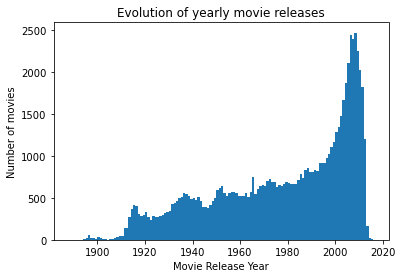

In [356]:
n_bins = int(movie_meta['movie_release_year'].dropna().max() - movie_meta['movie_release_year'].dropna().min())
movie_meta['movie_release_year'].plot.hist(bins=n_bins)

plt.xlabel('Movie Release Year')
plt.ylabel('Number of movies')
plt.title('Evolution of yearly movie releases')
plt.show()

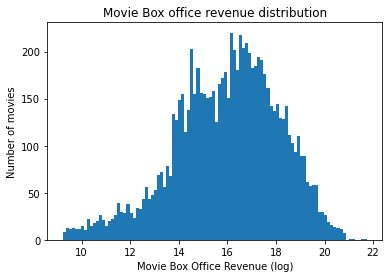

In [357]:
np.log(movie_meta['movie_box_office_revenue']).plot.hist(bins=100)

plt.xlabel('Movie Box Office Revenue (log)')
plt.ylabel('Number of movies')
plt.title('Movie Box office revenue distribution')
plt.show()

In [358]:
# Read imdb to fix data
# imdb_title_basics = pd.read_csv(IMDB_TITLE_BASICS, sep='\t')
# imdb_title_basics.columns = ['imdb_' + cn for cn in imdb_title_basics.columns]

In [359]:
# # display null values
# imdb_title_basics.isna().sum()

In [360]:
# movie_meta_imdb_merged = movie_meta.merge(imdb_title_basics, how='left', left_on='movie_name', right_on='imdb_primaryTitle')

In [361]:
# movie_meta_imdb_merged.head()

In [362]:
# imdb_title_basics.head()

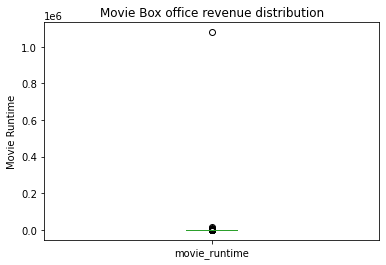

0     98.0
1     95.0
2     83.0
3    110.0
4    106.0
Name: movie_runtime, dtype: float64

In [363]:
# Distribution of movie runtime
movie_meta['movie_runtime'].plot.box()

plt.ylabel('Movie Runtime')
plt.title('Movie Box office revenue distribution')
plt.show()
movie_meta['movie_runtime'].head()

In [364]:
# Display outliers
movie_meta.sort_values(by='movie_runtime', ascending=False).head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year
12804,10815585,/m/02qqy23,Zero Tolerance,1995-01-01,NaN,1079281.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/0lsxr"": ""Crime Fiction"", ""/m/02kdv5l"": ""Action"", ""/m/0219x_"": ""Indie"", ""/m/03btsm8"": ""Action/Adventure""}",1995.0
62962,32441022,/m/0gyr803,Modern Times Forever,NaT,NaN,14400.0,{},{},"{""/m/0jtdp"": ""Documentary""}",NaN
71100,25345684,/m/09gqhh3,Cinématon,2011-01-01,NaN,9360.0,"{""/m/064_8sq"": ""French Language""}","{""/m/0f8l9c"": ""France""}","{""/m/0424mc"": ""Experimental film"", ""/m/0jtdp"": ""Documentary""}",2011.0
21733,14545195,/m/03qcghh,Matrjoschka,2006-04-23,NaN,5700.0,{},"{""/m/0345h"": ""Germany""}","{""/m/0219x_"": ""Indie"", ""/m/0jtdp"": ""Documentary""}",2006.0
46666,884435,/m/03lmv2,The Cure for Insomnia,1987-01-31,NaN,5220.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4lw"": ""Art film""}",1987.0


To fix outliers and missing values, we plan to use the imdb dataset to find if we can extract the values from it.

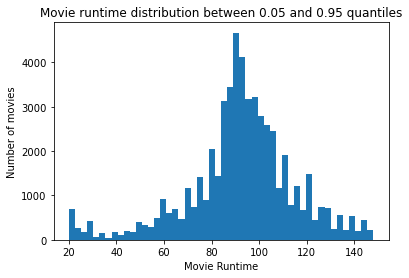

In [365]:
# Distribution of movie runtime
# We display values between 0.05 and 0.95 quantiles as we will fix the outliers with the imdb dataset
display_range = (movie_meta['movie_runtime'].quantile(0.05), movie_meta['movie_runtime'].quantile(0.95))
movie_meta['movie_runtime'].plot.hist(bins=50, range=display_range)

plt.xlabel('Movie Runtime')
plt.ylabel('Number of movies')
plt.title('Movie runtime distribution between 0.05 and 0.95 quantiles')
plt.show()

In [366]:
test_meta = movie_meta

In [367]:
test_meta.loc[:, 'movie_languages_ids'] = test_meta['movie_languages'].apply(lambda x: ast.literal_eval(x).values())
test_meta.loc[:, 'movie_countries_ids'] = test_meta['movie_countries'].apply(lambda x: ast.literal_eval(x).values())
test_meta.loc[:, 'movie_genres_ids'] = test_meta['movie_genres'].apply(lambda x: ast.literal_eval(x).values())

In [368]:
language_ids = pd.Series([language for languages in test_meta['movie_languages_ids'] for language in languages])
language_counts = language_ids.value_counts()[:10]

country_ids = pd.Series([country for countries in test_meta['movie_countries_ids'] for country in countries])
country_counts = country_ids.value_counts()[:10]

genre_ids = pd.Series([genre for genres in test_meta['movie_genres_ids'] for genre in genres])
genre_counts = genre_ids.value_counts()[:10]

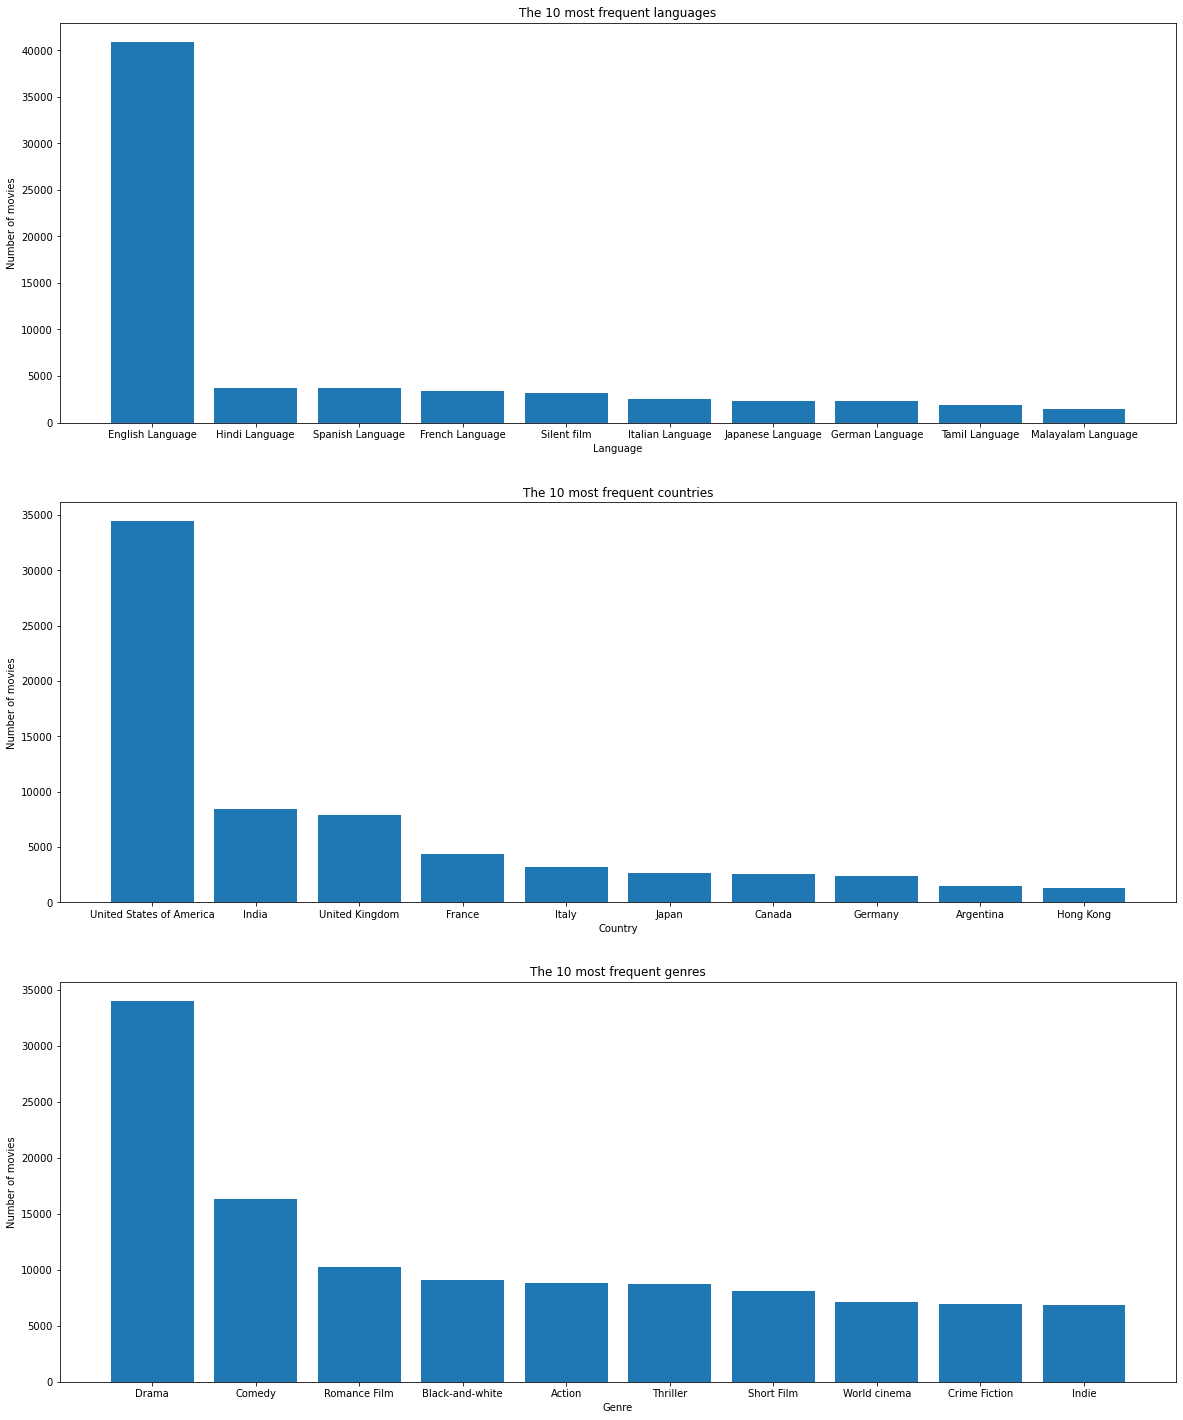

In [369]:
fig, (ax1, ax2, ax3) = plt.subplots(3, figsize=(20, 25))
ax1.bar(x=language_counts.index, height=language_counts.values)
ax1.set_xlabel('Language')
ax1.set_ylabel('Number of movies')
ax1.set_title('The 10 most frequent languages')

ax2.bar(x=country_counts.index, height=country_counts.values)
ax2.set_xlabel('Country')
ax2.set_ylabel('Number of movies')
ax2.set_title('The 10 most frequent countries')

ax3.bar(x=genre_counts.index, height=genre_counts.values)
ax3.set_xlabel('Genre')
ax3.set_ylabel('Number of movies')
ax3.set_title('The 10 most frequent genres')

plt.show()

#### Plot summaries

The plot summary file is extracted in a dataframe with the following attributes :

`wikipedia_movie_id`:  wikidata movie id  (str)    
`plot_summary`:  wikidata plot summary of the movie  (str) 

Preprocessing notes:
- indexing using the movie id
- nlp methods : using spaCy nlp framework
  ** tokenize
  ** parse 
  ** removing stop word
  ** lemmatise 
  ** topic prediction using Empath library 
  ** sentiment analysis using Vader
- joining this dataset with movie dataset
- character encoding
- remove wikipedia markup sign e.g {{hatnote}}

In [370]:
plot_summ.head(1)

,wikipedia_movie_id,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha, a saxophonist, develop a bizarre love-hate relationship, and despite their prejudices, realize they aren't so different after all."


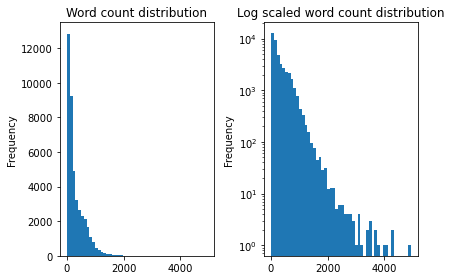

In [371]:
# Using trivial tokenizer
plot_summ['count'] = plot_summ['summary'].apply(lambda x: len(x.split()))

fig, axes = plt.subplots(nrows=1, ncols=2)
plot_summ['count'].plot(kind='hist', ax = axes[0], bins=50)
plot_summ['count'].plot(kind='hist', logy=True, bins=50, ax=axes[1])
#plt.suptitle('Plot summary word count distribution', x=0.5, y=1.05, ha='center', fontsize='xx-large')
axes[0].title.set_text('Word count distribution')
axes[1].title.set_text('Log scaled word count distribution')
fig.tight_layout()

We can merge the two previous datasets namely containing namely plot_summary and movie_metadata information into a single dataframe. Unfortunately, the plot_summary dataframe contains the summary of 42303 movies far from the 81741 movies described in the movie_metadata dataframe. The intersection of the dataframes on movie_id yields 42204 collisions, meaning that 99 summaries were not matched with a movie. We will thus keep it as a separate dataframe in case we need it.

In [372]:
merged = pd.merge(movie_meta, plot_summ, left_on='wikipedia_movie_id', right_on='wikipedia_movie_id')

merged.index = merged.wikipedia_movie_id
merged = merged.drop(columns=['wikipedia_movie_id']).sort_values(by='wikipedia_movie_id')
merged.head(1)

,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,movie_languages_ids,movie_countries_ids,movie_genres_ids,summary,count
wikipedia_movie_id,,,,,,,,,,,,,,
330,/m/0ktn59,Actrius,1996-01-01,NaN,90.0,"{""/m/01m69"": ""Catalan language"", ""/m/06nm1"": ""Spanish Language""}","{""/m/06mkj"": ""Spain""}","{""/m/07s9rl0"": ""Drama"", ""/m/01t_vv"": ""Comedy-drama""}",1996.0,"(Catalan language, Spanish Language)",(Spain),"(Drama, Comedy-drama)","In order to prepare the role of an important old actress, a theatre student interviews three actresses who were her pupils: an international diva , a television star and a dubbing director .",33


#### Character 

The character metadata file is extracted in a dataframe with the following attributes :

`wikipedia_movie_id`:  wikidata movie id  ()  
`freebase_movie_id`:  freebase movie id  ()  
`release_date`:  unformated release date of the movie  ()   
`character_name`:  character name  ()  
`actor_date_of_birth`:  actor date of birth ()  
`actor_gender`:  actor gender (str)  
`actor_height`:  actor height ()  
`actor_ethnicity`: actor ethnicity specified with a freebase id   
`actor_name`:  actor name  ()  
`actor_age_movie_release`:  actor age at movie release date ()  
`freebase_character_to_actor`:   mapping from character freebase id to actor id ()  
`freebase_character_id`:  character freebase id ()  
`freebase_actor_id`:  actor freebase id ()


Preprocessing notes: 
- joining this character dataset with the previous dataframe on wikipedia movie id
- formatting the dates
- verify that the freebase id of the actor is unique so it can be used as an index for actors
- merge actor and character dataframe
- sentiment analysis on the m neighbours words surrounding the character name

In [373]:
character_meta.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character/actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


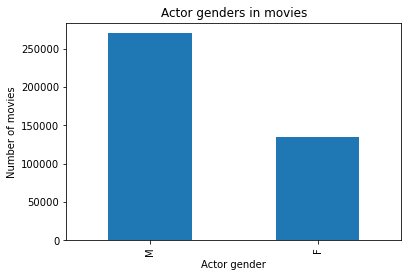

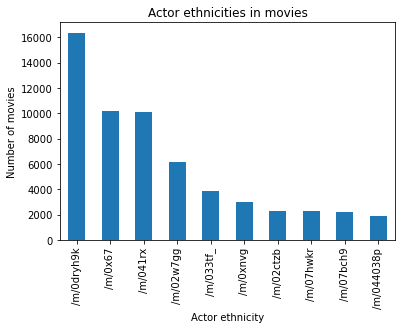

In [374]:
character_meta['actor_gender'].value_counts().plot.bar()
plt.xlabel('Actor gender')
plt.ylabel('Number of movies')
plt.title('Actor genders in movies')
plt.show()
character_meta['actor_ethnicity_id'].value_counts()[:10].plot.bar()
plt.xlabel('Actor ethnicity')
plt.ylabel('Number of movies')
plt.title('Actor ethnicities in movies')
plt.show()

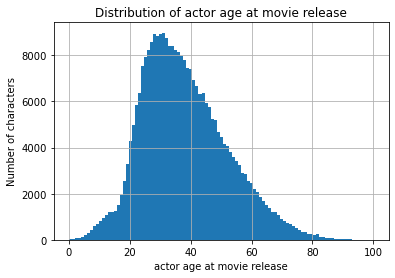

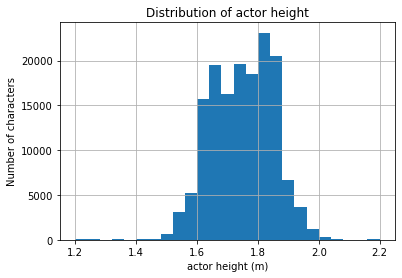

In [375]:
character_meta['actor_age_at_movie_release'].hist(bins=101, range=(0, 100))
plt.xlabel('actor age at movie release')
plt.ylabel('Number of characters')
plt.title('Distribution of actor age at movie release')
plt.show()
character_meta['actor_height_m'].hist(bins=25, range=(1.2, 2.2))
plt.xlabel('actor height (m)')
plt.ylabel('Number of characters')
plt.title('Distribution of actor height')
plt.show()

In [376]:
name_clusters.head()

,character_name,freebase_character/actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [377]:
name_clusters.nunique()

character_name                      970
freebase_character/actor_map_id    2661
dtype: int64

#### TV Tropes

The tv tropes file is extracted in a dataframe with the following attributes :

`character_type`:  short description of the character type (str)    
`freebase_character/actor_map_id`:  dictionnary containing character name, movie name, actor name and actor map id  (dict) 

In [378]:
tv_tropes.head()

,character_type,freebase_character/actor_map_id
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"": ""Flubber"", ""id"": ""/m/0jy9q0"", ""actor"": ""Robin Williams""}"
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richie Rich"", ""id"": ""/m/02vchl3"", ""actor"": ""Michael McShane""}"
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The Shadow"", ""id"": ""/m/0k6fkc"", ""actor"": ""Ian McKellen""}"
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!"", ""id"": ""/m/0k6_br"", ""actor"": ""Edmund Gwenn""}"
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate"", ""id"": ""/m/0k3rhh"", ""actor"": ""James Spader""}"


In [379]:
tv_tropes.nunique()

character_type                      72
freebase_character/actor_map_id    447
dtype: int64

As stated in the paper presenting the CMU datasets, there are 72 character/tv tropes types.  
Our next task is to combine the last three datasets into a single dataframe that will contain character/actor information : we can make use of the 'id' attribute inside the 'freebase_character/actor_map_id' column to merge this dataframe with the character dataframe.

Our ultimate goal is to create two dataframes : the first will be movie-centric that is indexed by the (wikipedia_id/freebase_id) and will contain cast information in the form of a list/dictionnary, the second will actor-centric that is indexed by the actor id (freebase_id) and will contain all the actor information, characters played and adjacent actors (ids of the actors they collaborated with).

In [380]:
name_clusters.head()

,character_name,freebase_character/actor_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [381]:
movie_meta.head()

,wikipedia_movie_id,freebase_movie_id,movie_name,movie_release_date,movie_box_office_revenue,movie_runtime,movie_languages,movie_countries,movie_genres,movie_release_year,movie_languages_ids,movie_countries_ids,movie_genres_ids
0,975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/01jfsb"": ""Thriller"", ""/m/06n90"": ""Science Fiction"", ""/m/03npn"": ""Horror"", ""/m/03k9fj"": ""Adventure"", ""/m/0fdjb"": ""Supernatural"", ""/m/02kdv5l"": ""Action"", ""/m/09zvmj"": ""Space western""}",2001.0,(English Language),(United States of America),"(Thriller, Science Fiction, Horror, Adventure, Supernatural, Action, Space western)"
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey Mystery,2000-02-16,NaN,95.0,"{""/m/02h40lc"": ""English Language""}","{""/m/09c7w0"": ""United States of America""}","{""/m/02n4kr"": ""Mystery"", ""/m/03bxz7"": ""Biographical film"", ""/m/07s9rl0"": ""Drama"", ""/m/0hj3n01"": ""Crime Drama""}",2000.0,(English Language),(United States of America),"(Mystery, Biographical film, Drama, Crime Drama)"
2,28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,"{""/m/05f_3"": ""Norwegian Language""}","{""/m/05b4w"": ""Norway""}","{""/m/0lsxr"": ""Crime Fiction"", ""/m/07s9rl0"": ""Drama""}",1988.0,(Norwegian Language),(Norway),"(Crime Fiction, Drama)"
3,9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,"{""/m/02h40lc"": ""English Language""}","{""/m/07ssc"": ""United Kingdom""}","{""/m/01jfsb"": ""Thriller"", ""/m/0glj9q"": ""Erotic thriller"", ""/m/09blyk"": ""Psychological thriller""}",1987.0,(English Language),(United Kingdom),"(Thriller, Erotic thriller, Psychological thriller)"
4,261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,"{""/m/04306rv"": ""German Language""}","{""/m/0345h"": ""Germany""}","{""/m/07s9rl0"": ""Drama""}",1983.0,(German Language),(Germany),(Drama)


In [382]:
character_meta.head()

,wikipedia_movie_id,freebase_movie_id,movie_release_date,character_name,actor_date_of_birth,actor_gender,actor_height_m,actor_ethnicity_id,actor_name,actor_age_at_movie_release,freebase_character/actor_map_id,freebase_character_id,freebase_actor_id
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [428]:
import matplotlib.pyplot as plt

In [430]:
from pyvis.network import Network
net = Network(notebook=True)

Local cdn resources have problems on chrome/safari when used in jupyter-notebook. 


In [383]:
# First, we want to make a list of actor entries, where for each actor entry we have a list of the movies they played in.

In [386]:
# We keep only the informations that we care about
actor_to_movies = character_meta[['freebase_actor_id','freebase_movie_id']]

In [396]:
actor_to_movies = entre.groupby('freebase_actor_id').apply(lambda x: list(x['freebase_movie_id']))

In [407]:
# We make it into a dictionary for convenience
actor_to_movies = dict(actor_to_movies)

In [408]:
movie_to_actors = character_meta[['freebase_actor_id','freebase_movie_id']].groupby('freebase_movie_id').apply(lambda x: list(x['freebase_actor_id']))

In [411]:
# We do something similar for movies
movie_to_actors = dict(entre3)

In [414]:
import networkx as nx

In [415]:
G = nx.graph.Graph()

In [418]:
# We make the first actor-to-actor graph.
# We construct the graph with actor nodes
for key in actor_to_movies.keys():
    G.add_node(key)

In [425]:
# For each actor, we get the movies he played in
for key in actor_to_movies.keys():
    set_of_movies = set(actor_to_movies[key])
    list_of_actors = []
    # For each movies, we get the list of actors that played in them
    for movie in set_of_movies:
        actors_for_one_movie = set(movie_to_actors[movie]) 
        list_of_actors += list(actors_for_one_movie)
    # We get a final list of all the actors an actor has co-starred with 
    # and remove the original actor so that we have no self-edge
    final_list_of_actors = set(list_of_actors) - set(key)
    # We transform the list of actors into a list of tuples of the shape (actor, actor) ( which will be the edges the networkx graph will add )
    final_list_of_actors = map(lambda x: (key, x), final_list_of_actors)
    # We add thes edges ( connections ) to the graph
    G.add_edges_from(final_list_of_actors)

In [426]:
G.size()

2219888

We have around 2,219,888 connections.

Text(0.5, 1.0, "Distribution of node's degrees")

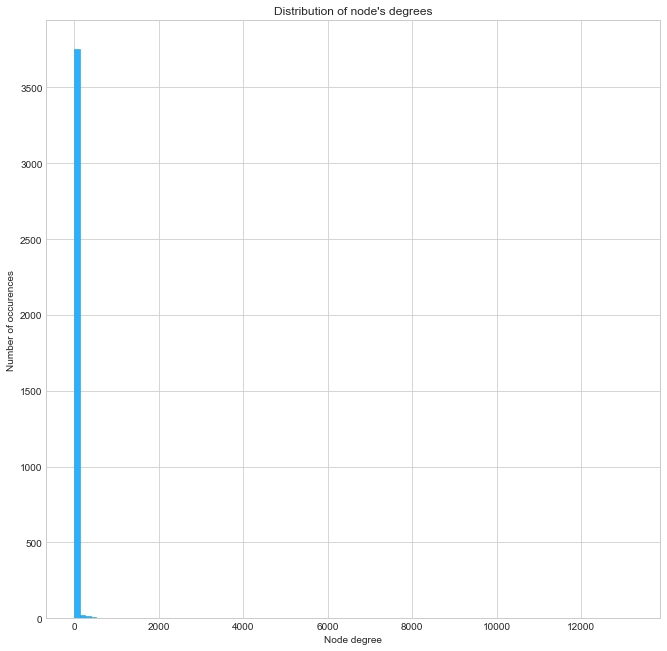

In [490]:
# We plot the distribution of the node's degrees.
plt.figure(figsize=(11,11))
plt.hist(nx.degree_histogram(G), log=False, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Node degree")
plt.ylabel("Number of occurences")
plt.title("Distribution of node's degrees")

Text(0.5, 1.0, "Distribution of node's degrees")

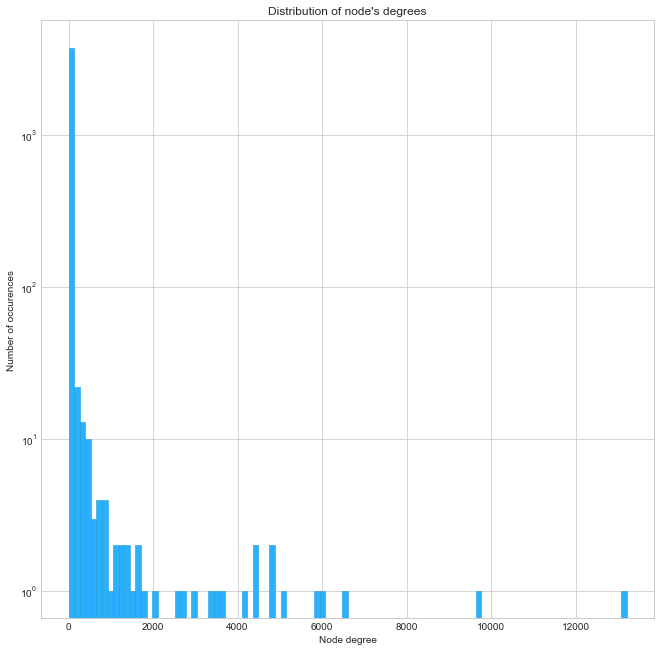

In [491]:
# We notice it looks like a heavy-tailed distribution so we apply a log-transform.
plt.figure(figsize=(11,11))
plt.hist(nx.degree_histogram(G), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Node degree")
plt.ylabel("Number of occurences")
plt.title("Distribution of node's degrees")

In [466]:
# We remove self-loop edges
G.remove_edges_from(nx.selfloop_edges(G))

In [494]:
len(G.nodes())

135761

In [495]:
G.size()

2084128

The graph we constructed has 135761 nodes and over 2,000,000 edges. We try to reduce the graph.

K-cores play an important role in revealing the higher-order organization of networks. So we apply this algorithm to obtain a graph that has a smaller number of nodes and edges.

In [467]:
G60 = nx.k_core(G, 60)

In [496]:
len(G60.nodes())

6490

In [468]:
G60.size()

422749

(array([1.216e+03, 6.200e+01, 4.600e+01, 1.300e+01, 1.900e+01, 1.900e+01,
        9.000e+00, 1.100e+01, 1.600e+01, 5.000e+00, 4.000e+00, 7.000e+00,
        5.000e+00, 7.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 2.000e+00,
        5.000e+00, 0.000e+00, 1.000e+00, 3.000e+00, 5.000e+00, 2.000e+00,
        2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 3.000e+00,
        2.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 2.000e+00, 1.000e+00,
        0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 0.000e+00,
        1.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

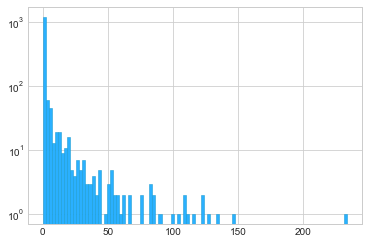

In [471]:
plt.hist(nx.degree_histogram(G60), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

We notice that we have a small group of very very connected nodes at the extreme right.

In [492]:
G100 = nx.k_core(G, 100)

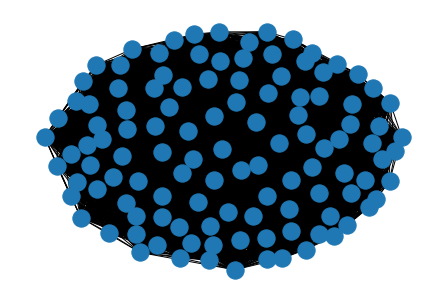

In [502]:
nx.draw(G100)

Graph is still unreadable.

(array([114.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([  0.  ,   1.15,   2.3 ,   3.45,   4.6 ,   5.75,   6.9 ,   8.05,
          9.2 ,  10.35,  11.5 ,  12.65,  13.8 ,  14.95,  16.1 ,  17.25,
         18.4 ,  19.55,  20.7 ,  21.85,  23.  ,  24.15,  25.3 ,  26.45,
         27.6 ,  28.75,  29.9 ,  31.05,  32.2 ,  33.35,  34.5 ,  35.65,
         36.8 ,  37.95,  39.1 

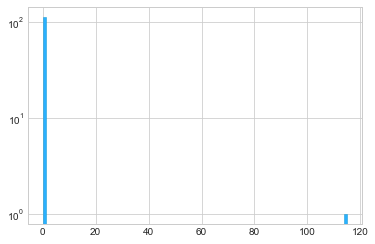

In [478]:
plt.hist(nx.degree_histogram(G100), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)

We do the same and make a movie-to-movie graph.

In [503]:
G2 = nx.graph.Graph()

In [508]:
# We make the movie-to-movie graph.
# We construct the graph with movie nodes
for key in movie_to_actors.keys():
    G2.add_node(key)

In [512]:
# For each movie, we get the actors that starred in it
for key in movie_to_actors.keys():
    set_of_actors = set(movie_to_actors[key])
    list_of_movies = []
    # For each movies, we get the list of actors that played in them
    for actor in set_of_actors:
        movies_for_one_actor = set(actor_to_movies.get(actor, {})) 
        list_of_movies += list(movies_for_one_actor)
    # We get a final list of all the movies a movie shares actors with
    # and remove the original movie so that we have no self-edge
    final_list_of_movies = set(list_of_movies) - set(key)
    # We transform the list of actors into a list of tuples of the shape (actor, actor) ( which will be the edges the networkx graph will add )
    final_list_of_movies = map(lambda x: (key, x), final_list_of_movies)
    # We add thes edges ( connections ) to the graph
    G2.add_edges_from(final_list_of_movies)

In [515]:
len(G2.nodes())

64330

In [516]:
G2.size()

4222612

We have 64,330 movies and 4,222,612 edges.

Text(0.5, 1.0, "Distribution of node's degrees")

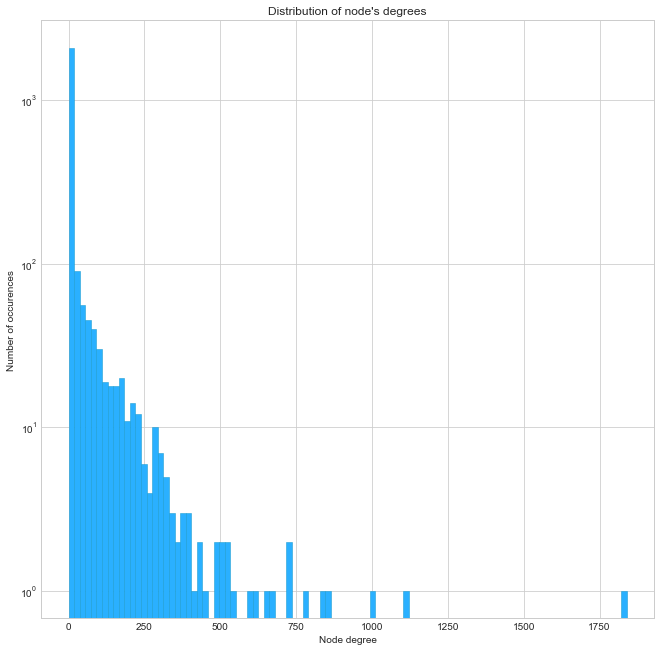

In [528]:
plt.figure(figsize=(11,11))
plt.hist(nx.degree_histogram(G2), log=True, bins=100, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.xlabel("Node degree")
plt.ylabel("Number of occurences")
plt.title("Distribution of node's degrees")

We once again, notice something similar, we have a group of movies at the extreme right that has a significantly higher node degree.

In [521]:
G2.remove_edges_from(nx.selfloop_edges(G2))

In [523]:
G2_60 = nx.k_core(G2)

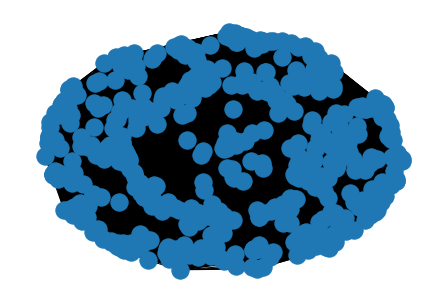

In [527]:
nx.draw(G2_60)